In [1]:
import os 
import re
import glob 
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from numpy import array
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta
import scipy
from scipy import stats,interpolate
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import MinMaxScaler


import random
import tensorflow 
import tensorflow as tf
random.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K
import warnings 
warnings.filterwarnings(action='ignore')

### 1.) 실험용 Train/ Test Data 업로드 

In [5]:
train = pd.read_csv('Train.csv',encoding='cp949')
test = pd.read_csv('Test.csv',encoding='cp949')
test = test[test['lot_no']!=20231215].reset_index(drop=True)
test = test[test['clusterSetting']!=176].reset_index(drop=True)
train.shape, test.shape

((9052, 132), (11277, 132))

In [6]:
train['clusterSetting'].value_counts()

182    3073
5      2654
23     1996
63      862
166     435
145      31
6         1
Name: clusterSetting, dtype: int64

In [7]:
train_submit = train #train[train['clusterSetting']!=63].sort_values(by='shotdatetime').reset_index(drop=True)

In [9]:
test_submit = test[test['clusterSetting']!=118].reset_index(drop=True)

In [13]:
submit_concat = pd.concat([train_submit,test_submit],axis=0).reset_index(drop=True).drop(['maker'],axis=1)

In [15]:
submit_concat.to_csv('submit_data.csv',encoding='cp949',index=False)

In [16]:
submit_concat.shape

(17496, 131)

In [4]:
test['clusterSetting'].value_counts()

5      5584
118    2833
182     971
40      732
63      682
23      475
Name: clusterSetting, dtype: int64

### 2.) 실험 개념 정리 
- 통합훈련 --> recipe 5,6,23,145,166,182 총합
- 통합예측 --> recipe 5,23,182 총합 
- 추가 예측 --> recipe 63, 23, 40

In [1]:
def build_autoencoder(X,outer,inner,latent_vector,function,dropout_ratio):
    random.seed(1234)
    np.random.seed(1234)
    tf.random.set_seed(1234)
    input_layer = Input(shape = (X.shape[1],))
    encoded = Dense(outer, activation = function,kernel_initializer='random_uniform',bias_initializer='zeros')(input_layer)
    encoded = Dropout(dropout_ratio)(encoded)
    encoded = Dense(inner, activation = function,kernel_initializer='random_uniform',bias_initializer='zeros')(encoded)
    encoded = Dense(latent_vector, activation = function)(encoded) 
    decoded = Dense(inner, activation = function,kernel_initializer='random_uniform',bias_initializer='zeros')(encoded)
    decoded = Dropout(dropout_ratio)(decoded)
    decoded = Dense(outer, activation = function,kernel_initializer='random_uniform',bias_initializer='zeros')(decoded)
    output_layer = Dense(X.shape[1], activation = function,kernel_initializer='random_uniform',bias_initializer='zeros')(decoded)
    autoencoder = Model(input_layer, output_layer)
    autoencoder.compile(optimizer='adam', loss='mae')
    return autoencoder

In [2]:
def train_autoencoder(train_number,model,X,batch,epoch,val): # ,patience
    if train_number==100:
        filename = 'autoencoder_item.h5'
    else:
        filename = 'autoencoder_best_weight_cluster='+str(train_number)+'.h5'
    checkpointer = ModelCheckpoint(filepath=filename,verbose=1,save_best_only=True)
    tensorboard = TensorBoard(log_dir='./logs',histogram_freq=0,write_graph=True,write_images=True)
    earlystopping = EarlyStopping(patience=200,verbose=0)
    history = model.fit(X, X,batch_size = batch, epochs = epoch, 
                        validation_split = val,callbacks=[checkpointer,tensorboard,earlystopping])
    print('\n')
    sns.set(font_scale=1.0)
    plt.figure(figsize=(6,4))
    plt.grid(True)
    if train_number==100:
        plt.title('Loss of Integrated Data')
    elif train_number==5:
        plt.title('Loss of Trained Recipe='+str(1))
    elif train_number==23:
        plt.title('Loss of Trained Recipe='+str(2))
    elif train_number==182:
        plt.title('Loss of Trained Recipe='+str(3))
    else:
        plt.title('Reconstruction Error of Trained Recipe='+str(train_number))
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='valid loss')
    plt.legend()
    plt.xlabel('Epoch'); plt.ylabel('loss')
    plt.show()
    return history 

In [3]:
def reconstruction_loss(model,x_train,train_number):
    x_train_pred  = model.predict(x_train)
    train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)
    q_3 = train_mae_loss.quantile(0.75)
    q_1 = train_mae_loss.quantile(0.25)
    iqr = q_3 - q_1
    iqr_threshold = q_3 + 1.5*iqr 
    statistical_threshold = train_mae_loss.mean() + 3*train_mae_loss.std()
    if train_number ==5:
        train_mae_loss = train_mae_loss[train_mae_loss<=0.06]
        threshold = train_mae_loss.max()
    else:
        threshold = train_mae_loss.max()
    print('\n')
    plt.figure(figsize=(6,4))
    if train_number==100:
        plt.title('Reconstruction Error of Integrated Data')
    elif train_number==5:
        plt.title('Reconstruction Error of Trained Recipe='+str(1))
    elif train_number==23:
        plt.title('Reconstruction Error of Trained Recipe='+str(2))
    elif train_number==182:
        plt.title('Reconstruction Error of Trained Recipe='+str(3))
    else:
        plt.title('Reconstruction Error of Trained Recipe='+str(train_number))
    plt.ylabel("Count")
    plt.xlabel("MAE values")
    plt.axvline(threshold,linestyle='dashdot',color='orange',label='Train Threshold')
    bins = 100
    plt.hist(train_mae_loss, bins=bins,color='blue',density=True,label='Train')
    plt.legend()
    plt.show()
    threshold_train = threshold 
    print('\n')
    print("Train (Normal Only) Reconstruction error threshold:", threshold_train)
    print('\n')
    train_mae_df = pd.DataFrame(train_mae_loss.describe()).rename(columns={0:'Train_MAE'})
    return train_mae_loss, threshold_train 

In [4]:
def anomaly_threshold(X,threshold,train_mae_loss,train_number,stage):
    test_score_df = pd.DataFrame(X[:])
    test_score_df['mae_loss'] = train_mae_loss # --> pred_proba
    test_score_df['threshold'] = threshold # 레이블 예측 임계값 
    test_score_df['anomaly'] = test_score_df['mae_loss'] > test_score_df['threshold']
    test_score_df['score'] = test_score_df["anomaly"].astype(int) # 예측 레이블 
    test_check = pd.concat([X.reset_index(drop=True),test_score_df['mae_loss'],test_score_df['threshold'],test_score_df['anomaly'],test_score_df['score']],axis=1)
    test_error = pd.DataFrame({'Reconstruction_error': test_score_df['mae_loss'],'Anomaly': test_score_df['score']})
    test_df = test_check[['mae_loss','threshold','anomaly','score']]
    test_good = test_df[test_df['score'] ==0]
    test_fault = test_df[test_df['score'] ==1]
    groups = test_error.groupby('Anomaly')
    fig, ax = plt.subplots(figsize = (8,3))
    for name, group in groups:
        ax.plot(group.index, group.Reconstruction_error, marker='+', ms=10, linestyle='',label= "Normal" if name == 0 else "Anomaly",color='blue' if name == 0 else "red")
    ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="orange", zorder=150, label='Anomaly Threshold')
    ax.legend()
    if train_number ==100:
        if stage=='Train':
            plt.title('Reconstruction Error of Trained Integrated Data')
        elif stage=='Valid':
            plt.title('Reconstruction Error of Validation Integrated Data')
        elif stage=='Test':
            plt.title('Reconstruction Error of Test Integrated Data')
        else:
            pass
    else:
        if stage=='Train':
            if train_number==5:
                plt.title('Reconstruction Error of Trained Recipe='+str(1))
            elif train_number==23:
                plt.title('Reconstruction Error of Trained Recipe='+str(2))
            elif train_number==182:
                plt.title('Reconstruction Error of Trained Recipe='+str(3))
            else:
                plt.title('Reconstruction Error of Trained Recipe='+str(train_number))
        elif stage=='Valid':
            if train_number==5:
                plt.title('Reconstruction Error of Validation Recipe='+str(1))
            elif train_number==23:
                plt.title('Reconstruction Error of Validation Recipe='+str(2))
            elif train_number==182:
                plt.title('Reconstruction Error of Validation Recipe='+str(3))
            else:
                plt.title('Reconstruction Error of Validation Recipe='+str(train_number))
        elif stage=='Test':
            if train_number==5:
                plt.title('Reconstruction Error of Test Recipe='+str(1))
            elif train_number==23:
                plt.title('Reconstruction Error of Test Recipe='+str(2))
            elif train_number==182:
                plt.title('Reconstruction Error of Test Recipe='+str(3))
            else:
                plt.title('Reconstruction Error of Test Recipe='+str(train_number))
    plt.ylabel("MAE values")
    plt.xlabel("Data Length")
    plt.grid(True)
    plt.show();
    return test_df,test_good,test_fault

In [5]:
def autoencoder(train_number,test_number,test):
    df = train
    if train_number==100:
        df = train
        df = df[(df['clusterSetting']==5)|(df['clusterSetting']==6)|(df['clusterSetting']==23)|(df['clusterSetting']==145)|(df['clusterSetting']==166)|(df['clusterSetting']==182)].reset_index(drop=True)
        df_train = df.sample(frac=0.8,random_state=2021).reset_index(drop=True)
        df_val = df.sample(frac=0.2,random_state=2021).reset_index(drop=True)
    else:
        df = df[df['clusterSetting']==train_number].reset_index(drop=True)
        print('Train Setting Cluster Number=',df['clusterSetting'].unique()[0])
        if len(df)>=1000:
            df_train = df.sample(frac=0.9,random_state=2021).reset_index(drop=True)
            df_val = df.sample(frac=0.1,random_state=2021).reset_index(drop=True)
        else:
            df_train = df.sample(frac=0.95,random_state=2021).reset_index(drop=True)
            df_val = df.sample(frac=0.05,random_state=2021).reset_index(drop=True)
    shot_cols =  df_train.loc[:, df_train.columns.str.contains('shotdata_')].columns.tolist()
    df_train = df_train[shot_cols]
    if 'shotdata_no' in df_train.columns.tolist():
        df_train = df_train.drop(['shotdata_no'],axis=1)
    else:
        pass
    df_inputs = df_train.loc[:, df_train.columns.str.contains('shotdata_')].dropna(axis=1)
    df_inputs = df_inputs.drop(['shotdata_cycle_time'],axis=1)
    print('Train Shape ==>',df_inputs.shape)
    X_train = df_inputs
    scaler = MinMaxScaler()
    scaler.fit(X_train) 
    X_train_scaled = pd.DataFrame(scaler.transform(X_train),columns = X_train.columns)
    X = X_train_scaled
    if train_number==100:
        outer=128
        inner=64
        latent_vector = 16
        dropout_ratio = 0.15
        function = 'tanh' # 'relu'
        batch = 100
        epoch = 200
        val = 0.15
    elif train_number==63:
        outer = 144 #128
        inner = 68 #64
        latent_vector = 2
        dropout_ratio = 0.01
        function='selu'
        batch = 1
        epoch = 200
        val = 0.05
    elif train_number==5:
        outer = 128
        inner = 64
        latent_vector = 4
        dropout_ratio = 0.1
        function = 'tanh' # 'relu'
        batch = 10
        epoch = 200
        val = 0.1
    else:
        outer = 64
        inner = 32
        latent_vector = 16
        dropout_ratio = 0.15
        function = 'tanh' # 'relu'
        batch = 10
        epoch = 200
        val = 0.15
    autoencoder = build_autoencoder(X,outer,inner,latent_vector,function,dropout_ratio)
    history = train_autoencoder(train_number,autoencoder,X,batch,epoch,val) # ,patience
    train_mae_loss, threshold_train = reconstruction_loss(autoencoder,X_train_scaled,train_number)  
    threshold = threshold_train
    stage='Train'
    train_df,train_good,train_fault = anomaly_threshold(X,threshold,train_mae_loss,train_number,stage)
    print(train_df['score'].value_counts())
    if train_df['score'].nunique()>1:
        print('학습 불량률 측정 ==> ',(train_df['score'].value_counts()[1]/len(train_df))*100,'%')
    else:
        pass
    print('=================================================================================================================')
    print('\n')

    shot_cols =  df_val.loc[:, df_val.columns.str.contains('shotdata_')].columns.tolist()
    df_val = df_val[shot_cols]
    if 'shotdata_no' in df_val.columns.tolist():
        df_val = df_val.drop(['shotdata_no'],axis=1)
    else:
        pass
    df_val_inputs = df_val.loc[:, df_val.columns.str.contains('shotdata_')].dropna(axis=1)
    df_val_inputs = df_val_inputs.drop(['shotdata_cycle_time'],axis=1)
    print('Valid Shape ==>',df_val_inputs.shape)
    X_val_scaled = pd.DataFrame(scaler.transform(df_val_inputs),columns = X_train.columns)
    if train_number==100:
        load_autoencoder = load_model('autoencoder_item.h5')
    else:
        load_autoencoder = load_model('autoencoder_best_weight_cluster='+str(train_number)+'.h5')
    x_val_pred  = load_autoencoder.predict(X_val_scaled)
    val_mae_loss = np.mean(np.abs(x_val_pred - X_val_scaled), axis=1) 
    if train_number==5:
        val_mae_loss = val_mae_loss[val_mae_loss<=0.04] # 0.075
    elif train_number==182:
        val_mae_loss = val_mae_loss[val_mae_loss<0.1]
    else:
        pass
    val_threshold = val_mae_loss.max()  
    print('\n')
    sns.set(font_scale=1.0)
    plt.figure(figsize=(6,4))
    plt.grid(True)
    if train_number==100:
        plt.title('Reconstruction Error of Validation Integrated Data')
    elif train_number==5:
        plt.title('Reconstruction Error of Validation Recipe='+str(1))
    elif train_number==23:
        plt.title('Reconstruction Error of Validation Recipe='+str(2))
    elif train_number==182:
        plt.title('Reconstruction Error of Validation Recipe='+str(3))
    else:
        plt.title('Reconstruction Error of Validation Recipe='+str(train_number))
    plt.ylabel("Count")
    plt.xlabel("MAE values")
    plt.axvline(val_threshold,linestyle='dashdot',color='orange',label='Anomaly Threshold')
    print('+ Max Validation Threshold=',val_mae_loss.max())
    if train_number==63: 
        plt.xlim(0,0.15)
    #elif train_number==100:
    #    plt.xlim(0,0.06)
    else:
        pass
    plt.hist(train_mae_loss, bins=100,color='blue',density=True,label='Train Normal')
    if train_number==63:
        plt.hist(val_mae_loss, bins=35,color='crimson',density=True,label='Valid Normal')
    else:
        plt.hist(val_mae_loss, bins=100,color='crimson',density=True,label='Valid Normal')
    plt.legend()
    plt.show()
    stage = 'Valid'
    val_df,val_good,val_fault = anomaly_threshold(X_val_scaled,val_threshold,val_mae_loss,train_number,stage)
    print(val_df['score'].value_counts())
    if val_df['score'].nunique()>1:
        print('검증 불량률 측정 ==> ',(val_df['score'].value_counts()[1]/len(val_df))*100,'%')
    else:
        pass
    print('=================================================================================================================')
    print('\n')

    df_test = test
    if test_number==100:
        df_test = test
        df_test = df_test[(df_test['clusterSetting']==5)|(df_test['clusterSetting']==23)|(df_test['clusterSetting']==182)].reset_index(drop=True)
    else:
        df_test = df_test[df_test['clusterSetting']==test_number].reset_index(drop=True)
        print('Test Setting Cluster Number=',df_test['clusterSetting'].unique()[0])  
    shot_cols =  df_test.loc[:, df_test.columns.str.contains('shotdata_')].columns.tolist()
    df_test = df_test[shot_cols]
    if 'shotdata_no' in df_test.columns.tolist():
        df_test = df_test.drop(['shotdata_no'],axis=1)
    else:
        pass
    df_test_inputs = df_test.loc[:, df_test.columns.str.contains('shotdata_')].dropna(axis=1)
    df_test_inputs = df_test_inputs.drop(['shotdata_cycle_time'],axis=1)
    print('Test Shape ==>',df_test_inputs.shape)
    X_test_scaled = pd.DataFrame(scaler.transform(df_test_inputs),columns = X_train.columns)
    if train_number==100:
        load_autoencoder = load_model('autoencoder_item.h5')
    else:
        load_autoencoder = load_model('autoencoder_best_weight_cluster='+str(train_number)+'.h5')
    x_test_pred  = load_autoencoder.predict(X_test_scaled)
    test_mae_loss = np.mean(np.abs(x_test_pred - X_test_scaled), axis=1) 
    print('\n')
    sns.set(font_scale=1.0)
    plt.figure(figsize=(6,4))
    plt.grid(True)
    if test_number==100:
        plt.title('Reconstruction Error of Test Integrated Data')
    elif test_number==5:
        plt.title('Reconstruction Error of Test Recipe='+str(1))
    elif test_number==23:
        plt.title('Reconstruction Error of Test Recipe='+str(2))
    elif test_number==182:
        plt.title('Reconstruction Error of Test Recipe='+str(3))
    else:
        plt.title('Reconstruction Error of Test Recipe='+str(test_number))
    plt.ylabel("Count")
    plt.xlabel("MAE values")
    print('+ Max Validation Threshold=',val_mae_loss.max())
    max_threshold = val_mae_loss.max()
    plt.axvline(val_threshold,linestyle='dashdot',color='orange',label='Anomaly Threshold')
    if test_number==5:
        plt.xlim(0,0.1)
    elif test_number==63:
        plt.xlim(0,0.25)
    #elif test_number==100:
        #plt.xlim(0,0.2)
    else:
        pass
    if test_number==5:
        plt.hist(val_mae_loss, bins=100,color='blue',density=True,label='Valid Normal')
        plt.hist(test_mae_loss, bins=2500,color='crimson',density=True,label='Test Fault')
    elif test_number==23:
        plt.hist(val_mae_loss, bins=50,color='blue',density=True,label='Valid Normal')
        plt.hist(test_mae_loss, bins=100,color='crimson',density=True,label='Test Fault')
    elif test_number==63:
        plt.hist(val_mae_loss, bins=150,color='blue',density=True,label='Valid Normal')
        plt.hist(test_mae_loss, bins=150,color='crimson',density=True,label='Test Fault')
    else:
        plt.hist(val_mae_loss, bins=100,color='blue',density=True,label='Valid Normal')
        plt.hist(test_mae_loss, bins=100,color='crimson',density=True,label='Test Fault')   
    plt.legend()
    plt.show()
    print('추가 시도 대기 ==>')
    print('+ Max Validation Threshold=',val_mae_loss.max())
    stage = 'Test'
    val_threshold = val_mae_loss.max()
    test_df,test_good,test_fault = anomaly_threshold(X_test_scaled,val_threshold,test_mae_loss,test_number,stage)
    print(test_df['score'].value_counts())
    if test_df['score'].nunique()>1:
        print('테스트 불량률 측정 ==> ',(test_df['score'].value_counts()[1]/len(test_df))*100,'%')
    else:
        pass
    print('=================================================================================================================')
    print('\n')
    return test_df

In [7]:
train['clusterSetting'].value_counts()

182    3073
5      2654
23     1996
63      862
166     435
145      31
6         1
Name: clusterSetting, dtype: int64

In [8]:
test['clusterSetting'].value_counts().head(10)

5      5584
118    2833
182     971
40      732
63      682
23      475
Name: clusterSetting, dtype: int64

### 3.) Setting Cluster 기반 품목데이터 불량률 탐지 
- Cluster 5,23,182 Recipe-Based Anomaly Detection
- number=100은 전체 ITem 학습을 의미

#### 3-1.)

Train Setting Cluster Number= 5
Train Shape ==> (2389, 6)
Epoch 1/200
193/215 [=========================>....] - ETA: 0s - loss: 0.1361
Epoch 00001: val_loss improved from inf to 0.04960, saving model to autoencoder_best_weight_cluster=5.h5
215/215 [==============================] - 1s 3ms/step - loss: 0.1301 - val_loss: 0.0496
Epoch 2/200
191/215 [=========================>....] - ETA: 0s - loss: 0.0465
Epoch 00002: val_loss improved from 0.04960 to 0.03914, saving model to autoencoder_best_weight_cluster=5.h5
215/215 [==============================] - 0s 2ms/step - loss: 0.0461 - val_loss: 0.0391
Epoch 3/200
182/215 [========================>.....] - ETA: 0s - loss: 0.0444
Epoch 00003: val_loss improved from 0.03914 to 0.03774, saving model to autoencoder_best_weight_cluster=5.h5
215/215 [==============================] - 0s 2ms/step - loss: 0.0445 - val_loss: 0.0377
Epoch 4/200
195/215 [==========================>...] - ETA: 0s - loss: 0.0432
Epoch 00004: val_loss did not improve fr

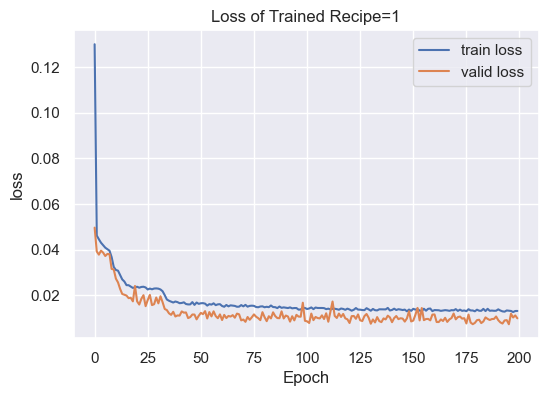

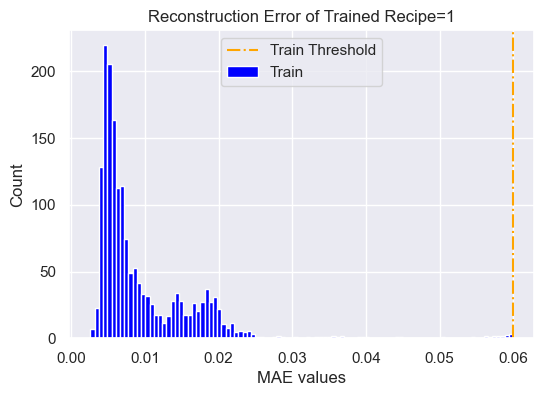



Train (Normal Only) Reconstruction error threshold: 0.05998688603521973




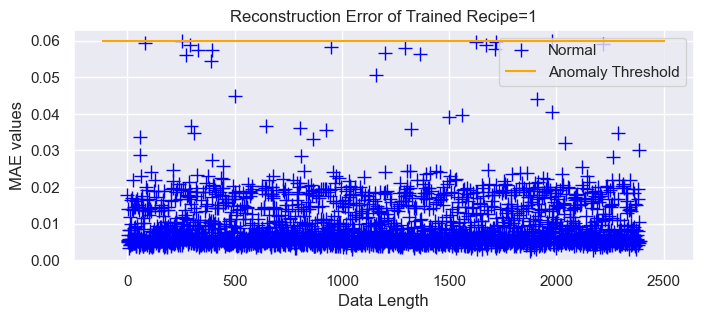

0    2389
Name: score, dtype: int64


Valid Shape ==> (265, 6)


+ Max Validation Threshold= 0.02731903549836386


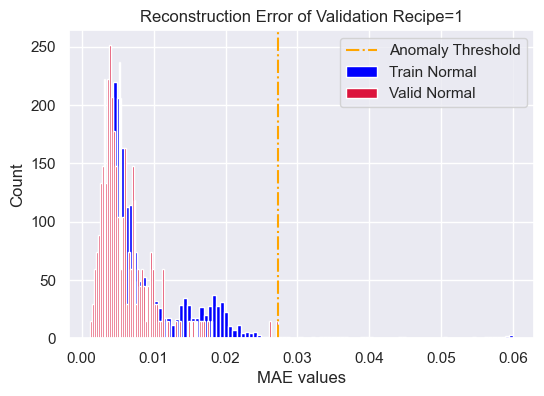

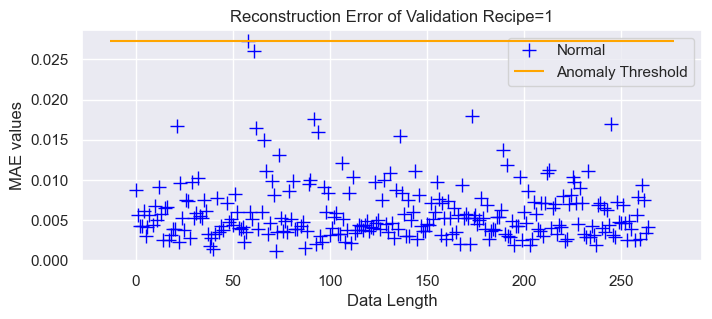

0    265
Name: score, dtype: int64


Test Setting Cluster Number= 5
Test Shape ==> (5584, 6)


+ Max Validation Threshold= 0.02731903549836386


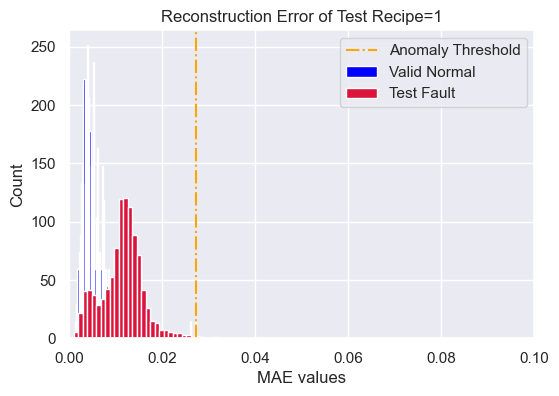

추가 시도 대기 ==>
+ Max Validation Threshold= 0.02731903549836386


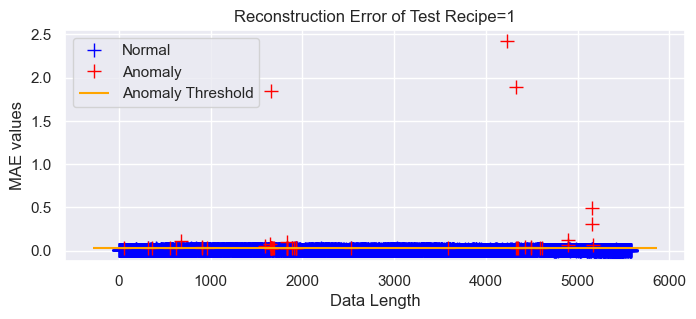

0    5536
1      48
Name: score, dtype: int64
테스트 불량률 측정 ==>  0.8595988538681949 %




In [9]:
df_pred = autoencoder(train_number=5,test_number=5,test=test)

In [10]:
cluster = 5
test_cluster = test[test['clusterSetting']==cluster].reset_index(drop=True)
test_cluster = test_cluster[['clusterSetting','lot_no','lot_fault_ratio','good_qty_sum','bad_qty_sum']]
result = pd.concat([test_cluster,df_pred[['mae_loss','threshold','score','anomaly']]],axis=1)
result['good_pred'] = result['score'].replace({0:1,1:0}) 
result['bad_pred'] = result['score']
count = result.groupby('lot_no')[['clusterSetting','good_qty_sum','bad_qty_sum']].mean()
lot_fault_ratio = result.groupby('lot_no')[['lot_fault_ratio']].mean()
pred_count = result.groupby('lot_no')[['good_pred','bad_pred']].sum()
sum = result.groupby('lot_no')[['good_pred','bad_pred']].sum()['bad_pred'] + result.groupby('lot_no')[['good_pred','bad_pred']].sum()['good_pred']
pred_fault_ratio = pd.DataFrame((result.groupby('lot_no')[['good_pred','bad_pred']].sum()['bad_pred']/sum)*100).rename(columns={0:'pred_fault_ratio'})
result_cluster5 = pd.concat([count,lot_fault_ratio,pred_count,pred_fault_ratio],axis=1)
result_cluster5

,clusterSetting,good_qty_sum,bad_qty_sum,lot_fault_ratio,good_pred,bad_pred,pred_fault_ratio
lot_no,,,,,,,
20240402,5.0,312.0,1.0,0.319489,312,1,0.319489
20240429,5.0,676.0,6.0,0.879765,674,8,1.173021
20240430,5.0,828.0,7.0,0.838323,822,13,1.556886
20240502,5.0,812.0,5.0,0.611995,807,10,1.223990
20240503,5.0,868.0,6.0,0.686499,874,0,0.000000
20240507,5.0,361.0,7.0,1.902174,367,1,0.271739
20240613,5.0,312.0,2.0,0.636943,314,0,0.000000
20240614,5.0,376.0,5.0,1.312336,373,8,2.099738
20240617,5.0,307.0,2.0,0.647249,307,2,0.647249


#### 3-2.) 

Train Setting Cluster Number= 23
Train Shape ==> (1796, 6)
Epoch 1/200
111/153 [====================>.........] - ETA: 0s - loss: 0.2377
Epoch 00001: val_loss improved from inf to 0.17043, saving model to autoencoder_best_weight_cluster=23.h5
153/153 [==============================] - 1s 3ms/step - loss: 0.2191 - val_loss: 0.1704
Epoch 2/200
134/153 [=========================>....] - ETA: 0s - loss: 0.1664
Epoch 00002: val_loss improved from 0.17043 to 0.17015, saving model to autoencoder_best_weight_cluster=23.h5
153/153 [==============================] - 0s 2ms/step - loss: 0.1680 - val_loss: 0.1701
Epoch 3/200
132/153 [========================>.....] - ETA: 0s - loss: 0.1655
Epoch 00003: val_loss improved from 0.17015 to 0.16806, saving model to autoencoder_best_weight_cluster=23.h5
153/153 [==============================] - 0s 2ms/step - loss: 0.1663 - val_loss: 0.1681
Epoch 4/200
118/153 [======================>.......] - ETA: 0s - loss: 0.1324
Epoch 00004: val_loss improved from 

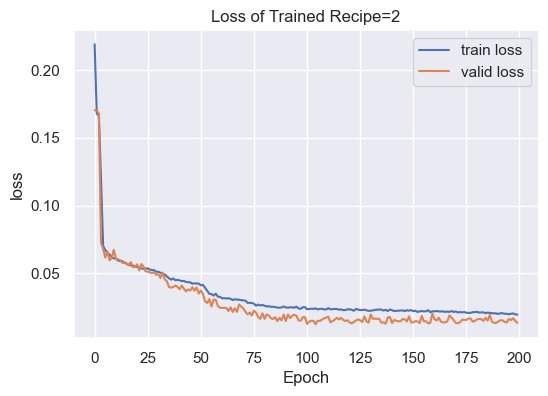

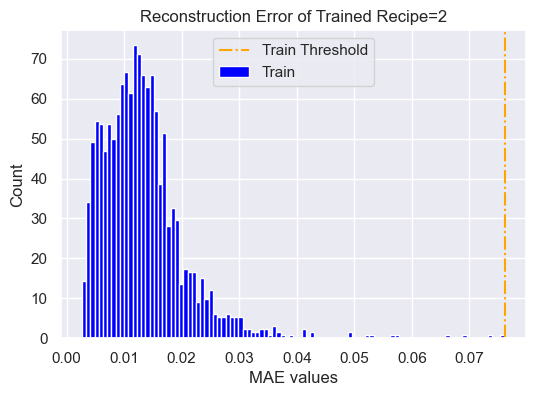



Train (Normal Only) Reconstruction error threshold: 0.07614049872882866




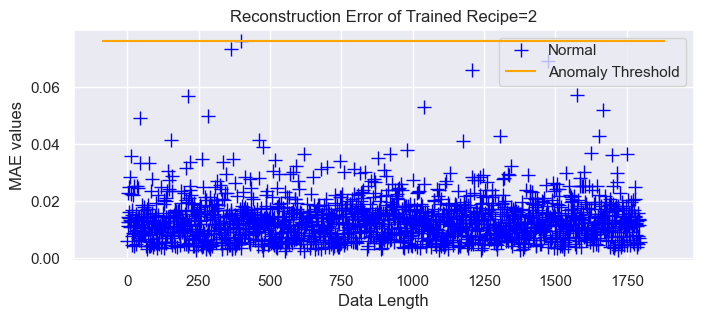

0    1796
Name: score, dtype: int64


Valid Shape ==> (200, 6)


+ Max Validation Threshold= 0.04377792687268541


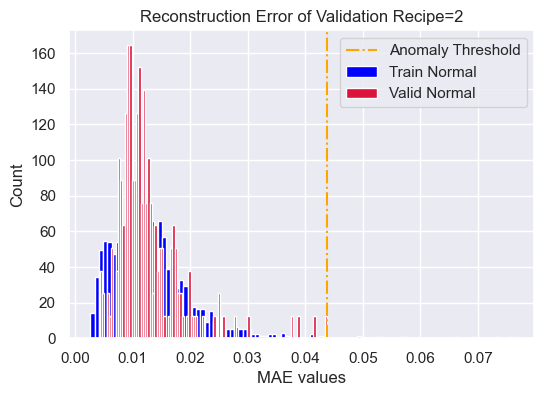

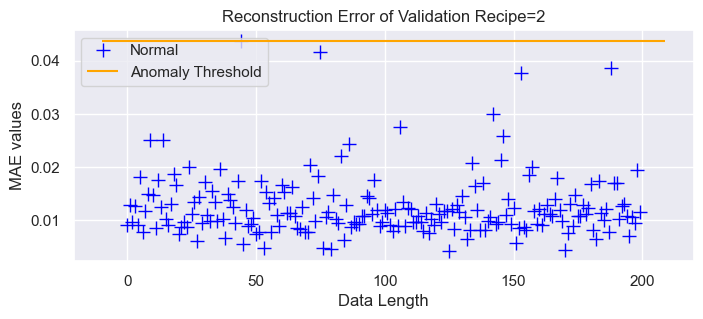

0    200
Name: score, dtype: int64


Test Setting Cluster Number= 23
Test Shape ==> (475, 6)


+ Max Validation Threshold= 0.04377792687268541


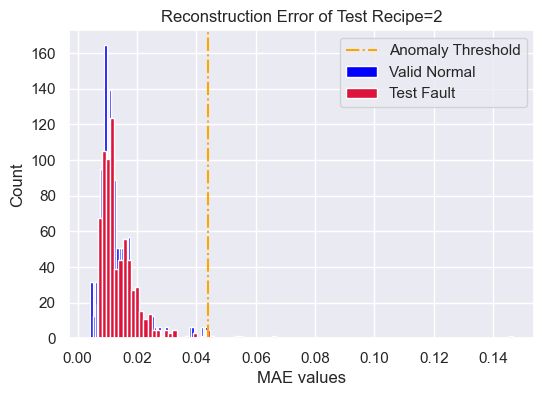

추가 시도 대기 ==>
+ Max Validation Threshold= 0.04377792687268541


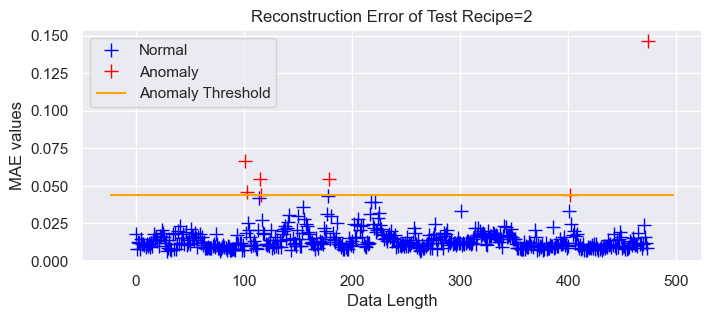

0    468
1      7
Name: score, dtype: int64
테스트 불량률 측정 ==>  1.4736842105263157 %




In [11]:
df_pred = autoencoder(train_number=23,test_number=23,test=test)

In [12]:
cluster = 23
test_cluster = test[test['clusterSetting']==cluster].reset_index(drop=True)
test_cluster = test_cluster[['clusterSetting','lot_no','lot_fault_ratio','good_qty_sum','bad_qty_sum']]
result = pd.concat([test_cluster,df_pred[['mae_loss','threshold','score','anomaly']]],axis=1)
result['good_pred'] = result['score'].replace({0:1,1:0}) 
result['bad_pred'] = result['score']
count = result.groupby('lot_no')[['clusterSetting','good_qty_sum','bad_qty_sum']].mean()
lot_fault_ratio = result.groupby('lot_no')[['lot_fault_ratio']].mean()
pred_count = result.groupby('lot_no')[['good_pred','bad_pred']].sum()
sum = result.groupby('lot_no')[['good_pred','bad_pred']].sum()['bad_pred'] + result.groupby('lot_no')[['good_pred','bad_pred']].sum()['good_pred']
pred_fault_ratio = pd.DataFrame((result.groupby('lot_no')[['good_pred','bad_pred']].sum()['bad_pred']/sum)*100).rename(columns={0:'pred_fault_ratio'})
result_cluster23 = pd.concat([count,lot_fault_ratio,pred_count,pred_fault_ratio],axis=1)
result_cluster23

,clusterSetting,good_qty_sum,bad_qty_sum,lot_fault_ratio,good_pred,bad_pred,pred_fault_ratio
lot_no,,,,,,,
20240717,23.0,474.0,1.0,0.210526,468,7,1.473684


#### 3-3.)

Train Setting Cluster Number= 182
Train Shape ==> (2766, 6)
Epoch 1/200
232/236 [============================>.] - ETA: 0s - loss: 0.2055
Epoch 00001: val_loss improved from inf to 0.17006, saving model to autoencoder_best_weight_cluster=182.h5
236/236 [==============================] - 1s 2ms/step - loss: 0.2046 - val_loss: 0.1701
Epoch 2/200
225/236 [===========================>..] - ETA: 0s - loss: 0.1466
Epoch 00002: val_loss improved from 0.17006 to 0.10248, saving model to autoencoder_best_weight_cluster=182.h5
236/236 [==============================] - 0s 2ms/step - loss: 0.1450 - val_loss: 0.1025
Epoch 3/200
214/236 [==========================>...] - ETA: 0s - loss: 0.0970
Epoch 00003: val_loss improved from 0.10248 to 0.09219, saving model to autoencoder_best_weight_cluster=182.h5
236/236 [==============================] - 0s 2ms/step - loss: 0.0974 - val_loss: 0.0922
Epoch 4/200
211/236 [=========================>....] - ETA: 0s - loss: 0.0943
Epoch 00004: val_loss did not im

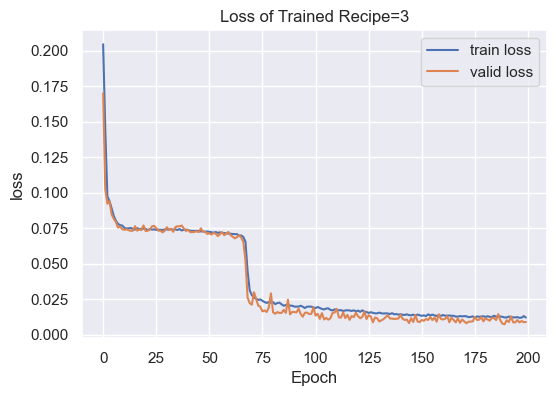

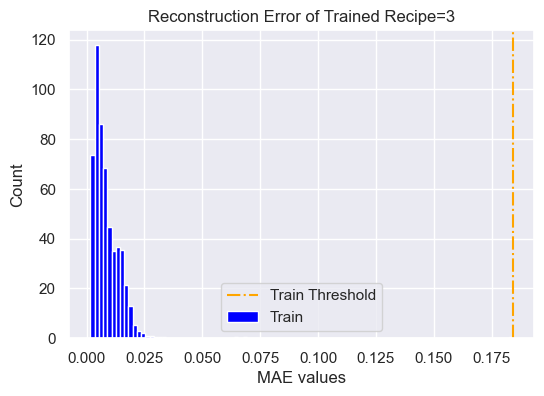



Train (Normal Only) Reconstruction error threshold: 0.18421740294839525




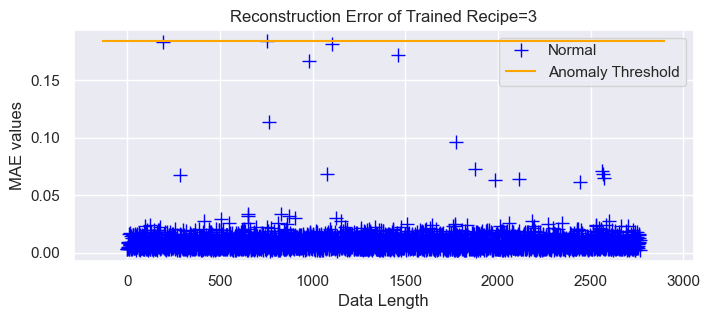

0    2766
Name: score, dtype: int64


Valid Shape ==> (307, 6)


+ Max Validation Threshold= 0.06351191546806782


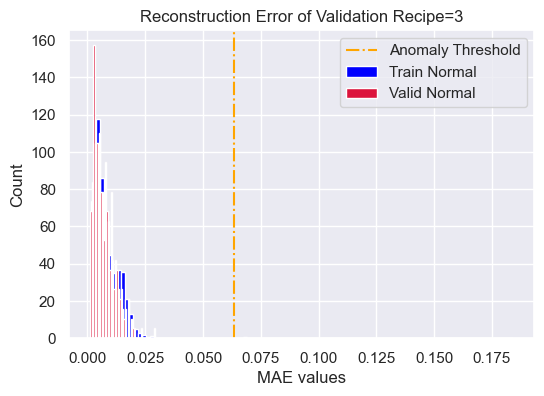

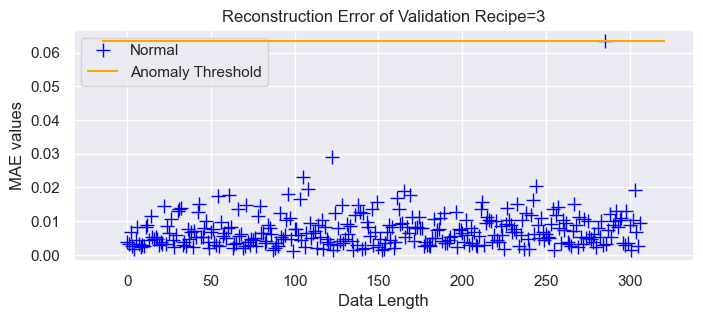

0    307
Name: score, dtype: int64


Test Setting Cluster Number= 182
Test Shape ==> (971, 6)


+ Max Validation Threshold= 0.06351191546806782


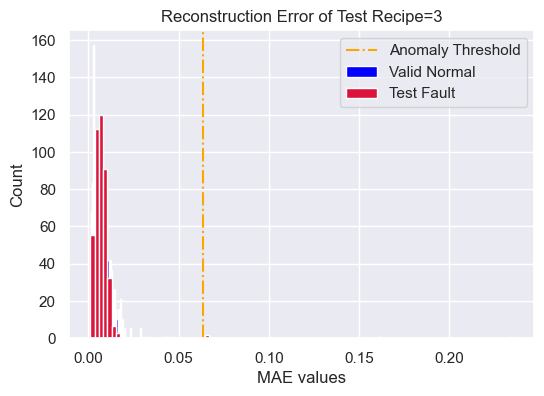

추가 시도 대기 ==>
+ Max Validation Threshold= 0.06351191546806782


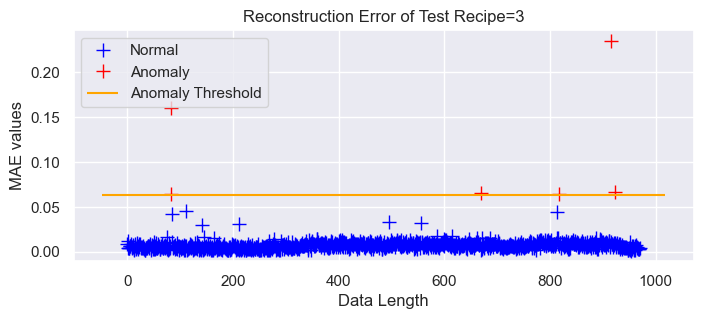

0    965
1      6
Name: score, dtype: int64
테스트 불량률 측정 ==>  0.6179196704428425 %




In [13]:
df_pred = autoencoder(train_number=182,test_number=182,test=test) 

In [14]:
cluster = 182
test_cluster = test[test['clusterSetting']==cluster].reset_index(drop=True)
test_cluster = test_cluster[['clusterSetting','lot_no','lot_fault_ratio','good_qty_sum','bad_qty_sum']]
result = pd.concat([test_cluster,df_pred[['mae_loss','threshold','score','anomaly']]],axis=1)
result['good_pred'] = result['score'].replace({0:1,1:0}) 
result['bad_pred'] = result['score']
count = result.groupby('lot_no')[['clusterSetting','good_qty_sum','bad_qty_sum']].mean()
lot_fault_ratio = result.groupby('lot_no')[['lot_fault_ratio']].mean()
pred_count = result.groupby('lot_no')[['good_pred','bad_pred']].sum()
sum = result.groupby('lot_no')[['good_pred','bad_pred']].sum()['bad_pred'] + result.groupby('lot_no')[['good_pred','bad_pred']].sum()['good_pred']
pred_fault_ratio = pd.DataFrame((result.groupby('lot_no')[['good_pred','bad_pred']].sum()['bad_pred']/sum)*100).rename(columns={0:'pred_fault_ratio'})
result_cluster182 = pd.concat([count,lot_fault_ratio,pred_count,pred_fault_ratio],axis=1)
result_cluster182

,clusterSetting,good_qty_sum,bad_qty_sum,lot_fault_ratio,good_pred,bad_pred,pred_fault_ratio
lot_no,,,,,,,
20240322,182.0,966.0,5.0,0.514933,965,6,0.61792


#### 3-4.) 

Train Shape ==> (6552, 6)
Epoch 1/200
56/56 [==============================] - ETA: 0s - loss: 0.2337
Epoch 00001: val_loss improved from inf to 0.17023, saving model to autoencoder_item.h5
56/56 [==============================] - 1s 7ms/step - loss: 0.2337 - val_loss: 0.1702
Epoch 2/200
50/56 [=========================>....] - ETA: 0s - loss: 0.1671
Epoch 00002: val_loss improved from 0.17023 to 0.16836, saving model to autoencoder_item.h5
56/56 [==============================] - 0s 5ms/step - loss: 0.1670 - val_loss: 0.1684
Epoch 3/200
50/56 [=========================>....] - ETA: 0s - loss: 0.1346
Epoch 00003: val_loss improved from 0.16836 to 0.05241, saving model to autoencoder_item.h5
56/56 [==============================] - 0s 5ms/step - loss: 0.1272 - val_loss: 0.0524
Epoch 4/200
51/56 [==========================>...] - ETA: 0s - loss: 0.0541
Epoch 00004: val_loss improved from 0.05241 to 0.04665, saving model to autoencoder_item.h5
56/56 [==============================] - 0s 5

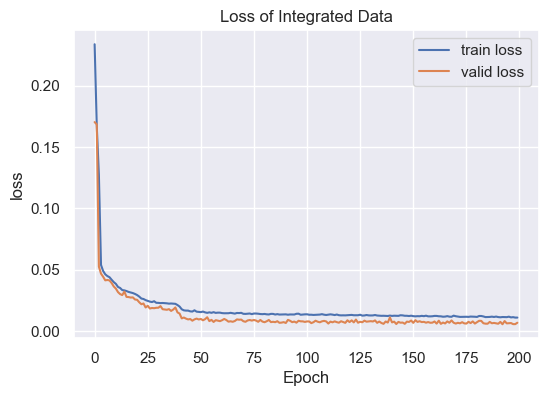

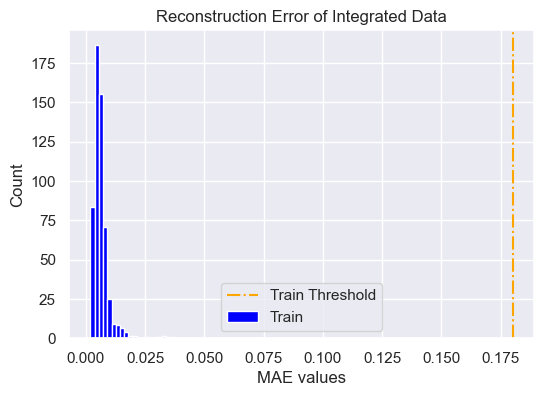



Train (Normal Only) Reconstruction error threshold: 0.1802202811202522




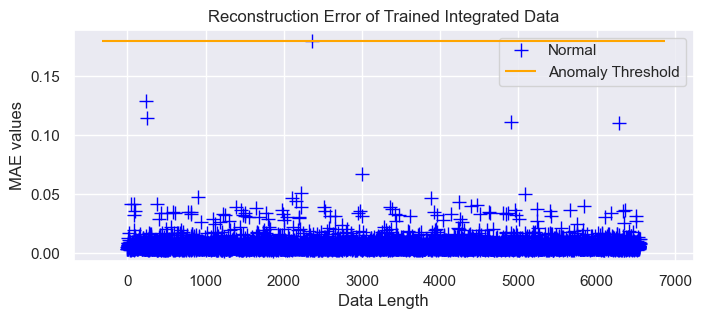

0    6552
Name: score, dtype: int64


Valid Shape ==> (1638, 6)


+ Max Validation Threshold= 0.1255956304878956


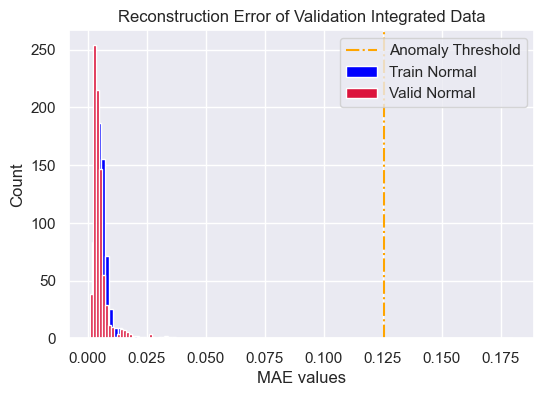

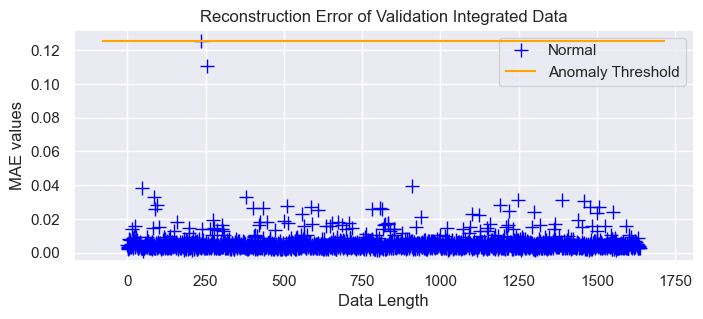

0    1638
Name: score, dtype: int64


Test Shape ==> (7030, 6)


+ Max Validation Threshold= 0.1255956304878956


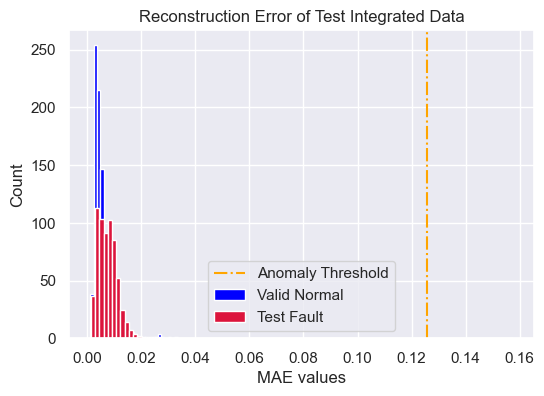

추가 시도 대기 ==>
+ Max Validation Threshold= 0.1255956304878956


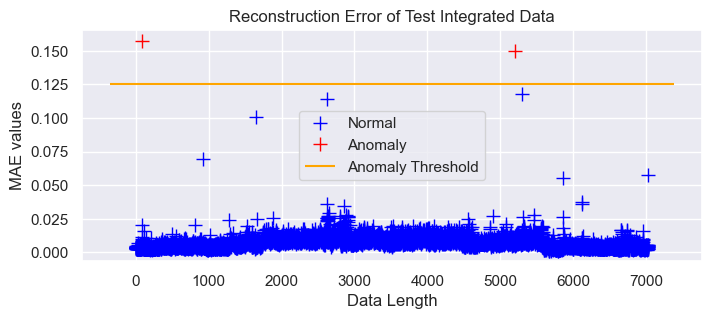

0    7028
1       2
Name: score, dtype: int64
테스트 불량률 측정 ==>  0.028449502133712664 %




In [15]:
df_test_all = autoencoder(train_number=100,test_number=100,test=test)

In [16]:
test_all = test[(test['clusterSetting']==5)|(test['clusterSetting']==23)|(test['clusterSetting']==182)].reset_index(drop=True)
test_all = test_all[['lot_no','lot_fault_ratio','good_qty_sum','bad_qty_sum']]
result = pd.concat([test_all,df_test_all [['mae_loss','threshold','score','anomaly']]],axis=1)
result['good_pred'] = result['score'].replace({0:1,1:0}) 
result['bad_pred'] = result['score']
count = result.groupby('lot_no')[['good_qty_sum','bad_qty_sum']].mean()
lot_fault_ratio = result.groupby('lot_no')[['lot_fault_ratio']].mean()
pred_count = result.groupby('lot_no')[['good_pred','bad_pred']].sum()
sum = result.groupby('lot_no')[['good_pred','bad_pred']].sum()['bad_pred'] + result.groupby('lot_no')[['good_pred','bad_pred']].sum()['good_pred']
pred_fault_ratio = pd.DataFrame((result.groupby('lot_no')[['good_pred','bad_pred']].sum()['bad_pred']/sum)*100).rename(columns={0:'pred_fault_ratio'})
result = pd.concat([count,lot_fault_ratio,pred_count,pred_fault_ratio],axis=1)
result = result.rename(columns={'good_pred':'good_pred_sum_INT','bad_pred':'bad_pred_sum_INT','pred_fault_ratio':'pred_fault_ratio_INT'})

result_clusters = pd.concat([result_cluster5.reset_index(),result_cluster23.reset_index(),result_cluster182.reset_index()],axis=0).reset_index(drop=True)
result_clusters = result_clusters.groupby('lot_no')[['good_pred','bad_pred','pred_fault_ratio','clusterSetting']].mean()
result_clusters = result_clusters.rename(columns={'good_pred':'good_pred_sum_REC','bad_pred':'bad_pred_sum_REC','pred_fault_ratio':'pred_fault_ratio_REC'})
result_concat = pd.concat([result,result_clusters],axis=1)
result_concat = result_concat.reset_index()
result_concat = result_concat[ (result_concat['lot_no']!=20240503) & (result_concat['lot_no']!=20240613) ].set_index('lot_no')

In [19]:
result_concat

,good_qty_sum,bad_qty_sum,lot_fault_ratio,good_pred_sum_INT,bad_pred_sum_INT,pred_fault_ratio_INT,good_pred_sum_REC,bad_pred_sum_REC,pred_fault_ratio_REC,clusterSetting
lot_no,,,,,,,,,,
20240322,966.0,5.0,0.514933,970,1,0.102987,965.0,6.0,0.617920,182.0
20240402,312.0,1.0,0.319489,313,0,0.000000,312.0,1.0,0.319489,5.0
20240429,676.0,6.0,0.879765,682,0,0.000000,674.0,8.0,1.173021,5.0
20240430,828.0,7.0,0.838323,835,0,0.000000,822.0,13.0,1.556886,5.0
20240502,812.0,5.0,0.611995,817,0,0.000000,807.0,10.0,1.223990,5.0
20240507,361.0,7.0,1.902174,368,0,0.000000,367.0,1.0,0.271739,5.0
20240614,376.0,5.0,1.312336,380,1,0.262467,373.0,8.0,2.099738,5.0
20240617,307.0,2.0,0.647249,309,0,0.000000,307.0,2.0,0.647249,5.0
20240623,689.0,2.0,0.289436,691,0,0.000000,686.0,5.0,0.723589,5.0


In [21]:
result_concat.sum()

good_qty_sum            5801.000000
bad_qty_sum               41.000000
lot_fault_ratio            7.526227
good_pred_sum_INT       5840.000000
bad_pred_sum_INT           2.000000
pred_fault_ratio_INT       0.365454
good_pred_sum_REC       5781.000000
bad_pred_sum_REC          61.000000
pred_fault_ratio_REC      10.107305
clusterSetting           245.000000
dtype: float64

### 4.) Cluster 5,23,182 외에 Adaptable Learning Prediction


#### 4-1.) 추가 학습 & 예측 

Train Setting Cluster Number= 63
Train Shape ==> (819, 6)
Epoch 1/200
747/778 [===========================>..] - ETA: 0s - loss: 0.1314
Epoch 00001: val_loss improved from inf to 0.08235, saving model to autoencoder_best_weight_cluster=63.h5
778/778 [==============================] - 2s 1ms/step - loss: 0.1301 - val_loss: 0.0823
Epoch 2/200
777/778 [============================>.] - ETA: 0s - loss: 0.0999
Epoch 00002: val_loss did not improve from 0.08235
778/778 [==============================] - 1s 1ms/step - loss: 0.0998 - val_loss: 0.0974
Epoch 3/200
750/778 [===========================>..] - ETA: 0s - loss: 0.0908
Epoch 00003: val_loss improved from 0.08235 to 0.07719, saving model to autoencoder_best_weight_cluster=63.h5
778/778 [==============================] - 1s 2ms/step - loss: 0.0906 - val_loss: 0.0772
Epoch 4/200
759/778 [============================>.] - ETA: 0s - loss: 0.0872
Epoch 00004: val_loss improved from 0.07719 to 0.07420, saving model to autoencoder_best_weight_

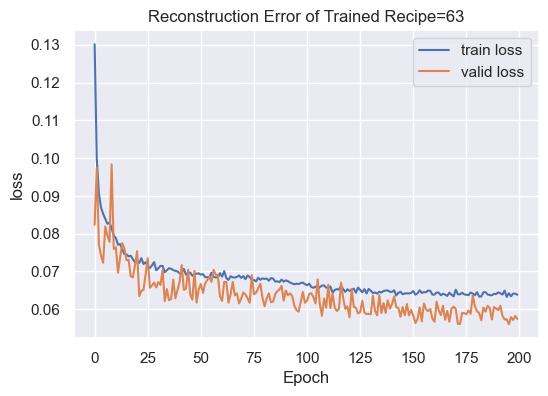

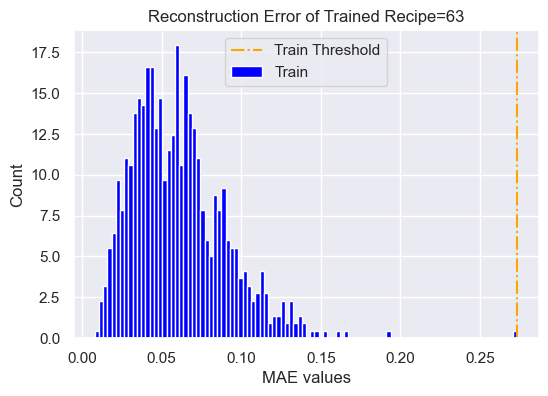



Train (Normal Only) Reconstruction error threshold: 0.27340742276473584




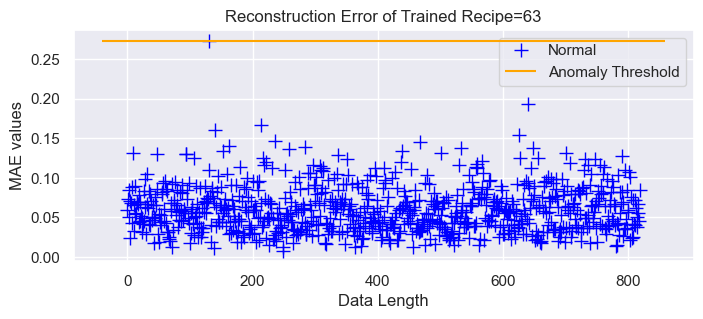

0    819
Name: score, dtype: int64


Valid Shape ==> (43, 6)


+ Max Validation Threshold= 0.16148069438012902


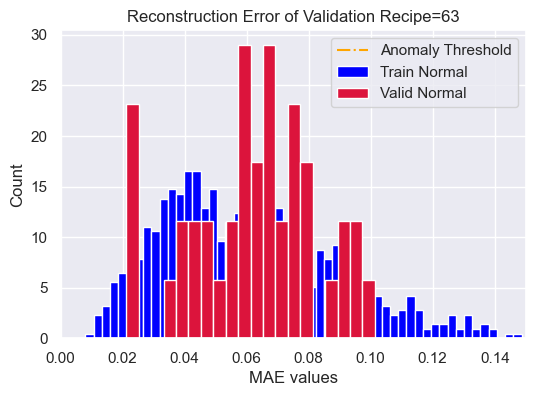

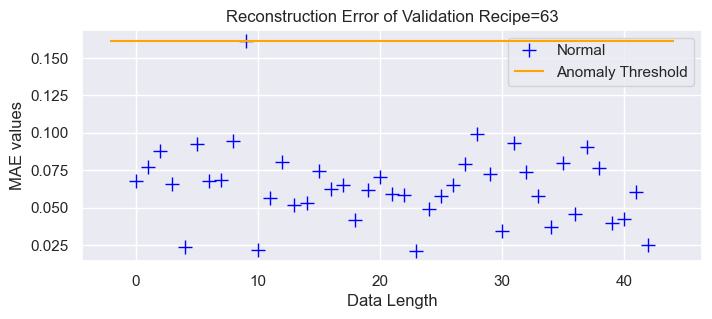

0    43
Name: score, dtype: int64


Test Setting Cluster Number= 63
Test Shape ==> (682, 6)


+ Max Validation Threshold= 0.16148069438012902


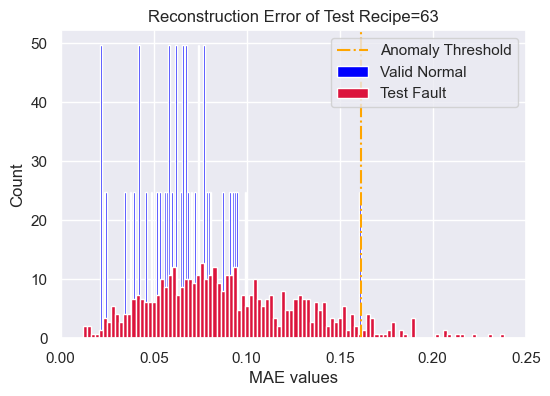

추가 시도 대기 ==>
+ Max Validation Threshold= 0.16148069438012902


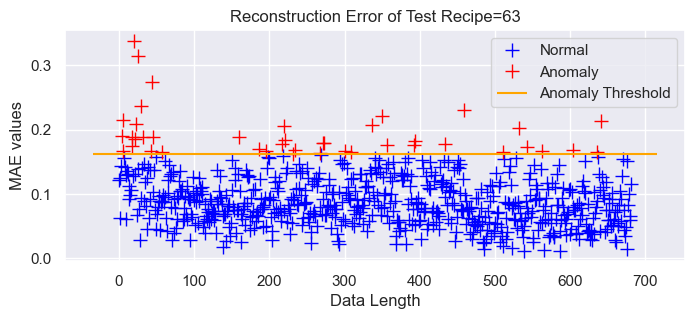

0    640
1     42
Name: score, dtype: int64
테스트 불량률 측정 ==>  6.158357771260997 %




,clusterSetting,good_qty_sum,bad_qty_sum,lot_fault_ratio,good_pred,bad_pred,pred_fault_ratio
lot_no,,,,,,,
20240124,63.0,680.0,2.0,0.293255,640,42,6.158358


In [25]:
df_pred = autoencoder(train_number=63,test_number=63,test=test)

cluster = 63
test_cluster = test[test['clusterSetting']==cluster].reset_index(drop=True)
test_cluster = test_cluster[['clusterSetting','lot_no','lot_fault_ratio','good_qty_sum','bad_qty_sum']]
result = pd.concat([test_cluster,df_pred[['mae_loss','threshold','score','anomaly']]],axis=1)
result['good_pred'] = result['score'].replace({0:1,1:0}) 
result['bad_pred'] = result['score']
count = result.groupby('lot_no')[['clusterSetting','good_qty_sum','bad_qty_sum']].mean()
lot_fault_ratio = result.groupby('lot_no')[['lot_fault_ratio']].mean()
pred_count = result.groupby('lot_no')[['good_pred','bad_pred']].sum()
sum = result.groupby('lot_no')[['good_pred','bad_pred']].sum()['bad_pred'] + result.groupby('lot_no')[['good_pred','bad_pred']].sum()['good_pred']
pred_fault_ratio = pd.DataFrame((result.groupby('lot_no')[['good_pred','bad_pred']].sum()['bad_pred']/sum)*100).rename(columns={0:'pred_fault_ratio'})
result_cluster63 = pd.concat([count,lot_fault_ratio,pred_count,pred_fault_ratio],axis=1)
result_cluster63

#### 4-2.) 통합 모델 예측 

Train Shape ==> (6552, 6)
Epoch 1/200
55/56 [============================>.] - ETA: 0s - loss: 0.2344
Epoch 00001: val_loss improved from inf to 0.17023, saving model to autoencoder_item.h5
56/56 [==============================] - 1s 7ms/step - loss: 0.2337 - val_loss: 0.1702
Epoch 2/200
50/56 [=========================>....] - ETA: 0s - loss: 0.1671
Epoch 00002: val_loss improved from 0.17023 to 0.16836, saving model to autoencoder_item.h5
56/56 [==============================] - 0s 5ms/step - loss: 0.1670 - val_loss: 0.1684
Epoch 3/200
37/56 [==================>...........] - ETA: 0s - loss: 0.1565
Epoch 00003: val_loss improved from 0.16836 to 0.05241, saving model to autoencoder_item.h5
56/56 [==============================] - 0s 4ms/step - loss: 0.1272 - val_loss: 0.0524
Epoch 4/200
55/56 [============================>.] - ETA: 0s - loss: 0.0538
Epoch 00004: val_loss improved from 0.05241 to 0.04665, saving model to autoencoder_item.h5
56/56 [==============================] - 0s 4

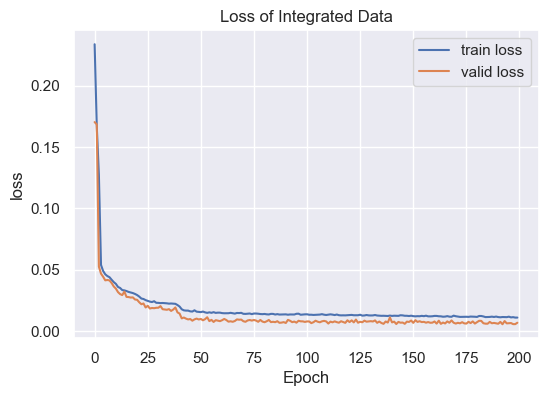

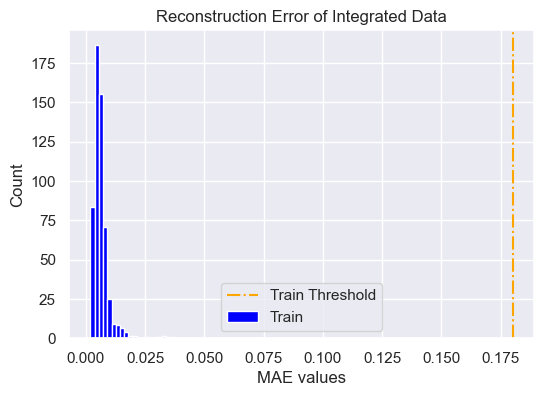



Train (Normal Only) Reconstruction error threshold: 0.1802202811202522




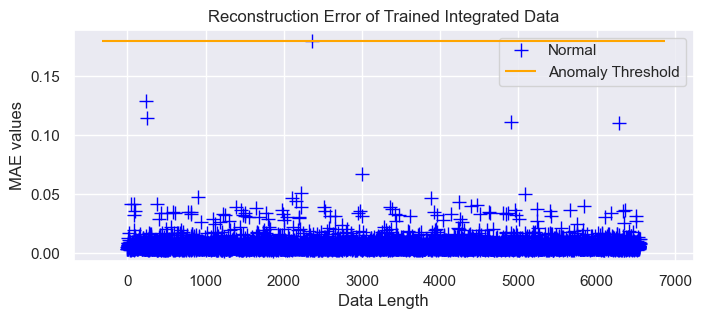

0    6552
Name: score, dtype: int64


Valid Shape ==> (1638, 6)


+ Max Validation Threshold= 0.1255956304878956


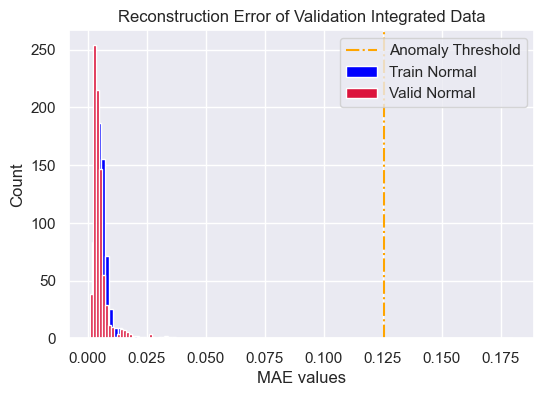

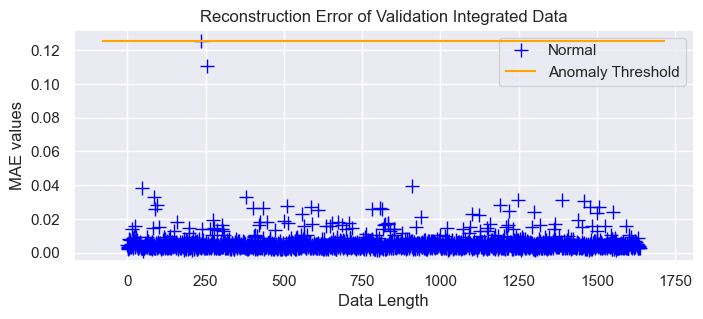

0    1638
Name: score, dtype: int64


Test Setting Cluster Number= 63
Test Shape ==> (682, 6)


+ Max Validation Threshold= 0.1255956304878956


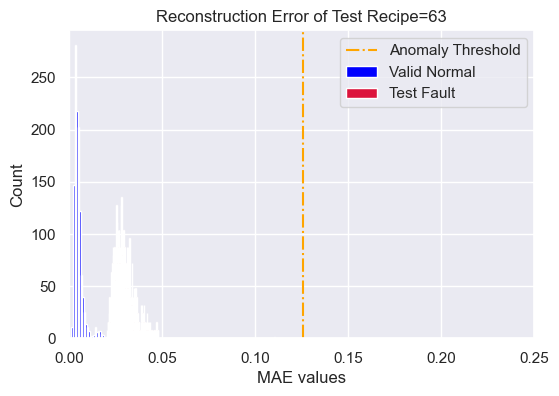

추가 시도 대기 ==>
+ Max Validation Threshold= 0.1255956304878956


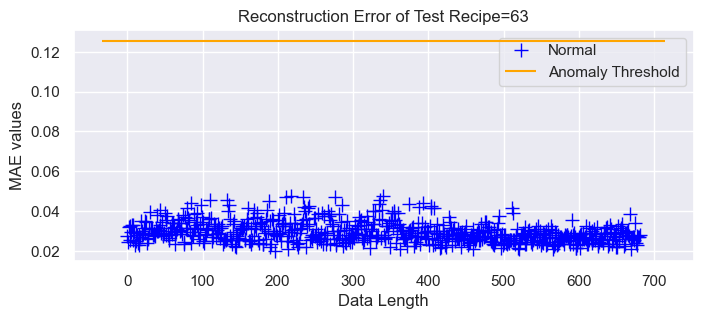

0    682
Name: score, dtype: int64




,clusterSetting,good_qty_sum,bad_qty_sum,lot_fault_ratio,good_pred,bad_pred,pred_fault_ratio
lot_no,,,,,,,
20240124,63.0,680.0,2.0,0.293255,682,0,0.0


In [26]:
df_pred = autoencoder(train_number=100,test_number=63,test=test)

cluster = 63
test_cluster = test[test['clusterSetting']==cluster].reset_index(drop=True)
test_cluster = test_cluster[['clusterSetting','lot_no','lot_fault_ratio','good_qty_sum','bad_qty_sum']]
result = pd.concat([test_cluster,df_pred[['mae_loss','threshold','score','anomaly']]],axis=1)
result['good_pred'] = result['score'].replace({0:1,1:0}) 
result['bad_pred'] = result['score']
count = result.groupby('lot_no')[['clusterSetting','good_qty_sum','bad_qty_sum']].mean()
lot_fault_ratio = result.groupby('lot_no')[['lot_fault_ratio']].mean()
pred_count = result.groupby('lot_no')[['good_pred','bad_pred']].sum()
sum = result.groupby('lot_no')[['good_pred','bad_pred']].sum()['bad_pred'] + result.groupby('lot_no')[['good_pred','bad_pred']].sum()['good_pred']
pred_fault_ratio = pd.DataFrame((result.groupby('lot_no')[['good_pred','bad_pred']].sum()['bad_pred']/sum)*100).rename(columns={0:'pred_fault_ratio'})
result_cluster63 = pd.concat([count,lot_fault_ratio,pred_count,pred_fault_ratio],axis=1)
result_cluster63

In [27]:
import math
import scipy
from scipy.special import kl_div

In [28]:
df_trained_clusters = train
set_cols = df_trained_clusters.loc[:, df_trained_clusters.columns.str.contains('param')].columns.tolist()

trained_settings = df_trained_clusters[set_cols+['clusterSetting']]
trained_settings['clusterSetting'].value_counts()

182    3073
5      2654
23     1996
63      862
166     435
145      31
6         1
Name: clusterSetting, dtype: int64

In [29]:
pd.set_option('display.max_rows',10)

In [30]:
def find_nearest_settings(number):
    cluster_settings = [5,23,182] #trained_settings['clusterSetting'].unique().tolist()
    dfs = []
    for i in range(0,len(cluster_settings)):
        trained_cluster = trained_settings[trained_settings['clusterSetting']==cluster_settings[i]].reset_index(drop=True)
        trained_cluster = trained_cluster.drop(['clusterSetting'],axis=1).drop_duplicates()
        trained_cluster2 = trained_settings[trained_settings['clusterSetting']==number].reset_index(drop=True)
        trained_cluster2 = trained_cluster2.drop(['clusterSetting'],axis=1).drop_duplicates()
        test_cluster = trained_cluster2
        kl_divergence = kl_div(trained_cluster, test_cluster).T.sum().iloc[0] # sum
        if kl_divergence == math.inf:
            kl_divergence= kl_div(test_cluster, trained_cluster).T.sum().iloc[0] # sum
        else:
            pass
        list_a = [cluster_settings[i],kl_divergence]
        dfs.append(list_a)
    lists_df = pd.DataFrame(dfs).rename(columns={0:'cluster_setting',1:'kl_div'})
    lists_df = lists_df[lists_df['kl_div']>=0]
    lists_df = lists_df.sort_values(by='kl_div',ascending=True).reset_index(drop=True)
    closest_list = lists_df[lists_df['kl_div']== lists_df['kl_div'].min()]
    closest_setting =  closest_list['cluster_setting'].iloc[0]
    return lists_df

In [31]:
lists_df = find_nearest_settings(number = 63)
lists_df

,cluster_setting,kl_div
0,5,40.100000
1,182,41.123767
2,23,41.634264


#### 4-3.) KL_DIV Fault Prediction

In [39]:
def kl_test(train_number,val_number,test_number):
    cols = train_setting.loc[:, train_setting.columns.str.contains('shotdata_')].drop(['shotdata_no','shotdata_cycle_time'],axis=1).columns.tolist()
    val_inputs = normal_val[cols]
    test_inputs = test_fault[cols]
    X_train = train_setting[cols]
    scaler = MinMaxScaler()
    scaler.fit(X_train) 
    X_val_scaled = pd.DataFrame(scaler.transform(val_inputs),columns = X_train.columns)
    if train_number==100:
        load_autoencoder = load_model('autoencoder_item.h5')
    else:
        load_autoencoder = load_model('autoencoder_best_weight_cluster='+str(train_number)+'.h5')
    x_val_pred  = load_autoencoder.predict(X_val_scaled)
    val_mae_loss = np.mean(np.abs(x_val_pred - X_val_scaled), axis=1) 
    if val_number==182:
        val_mae_loss = val_mae_loss[val_mae_loss<=0.12]
    else:
        pass
    print(val_mae_loss.max())
    val_threshold = val_mae_loss.max()
    val_score_df = pd.DataFrame(X_val_scaled[:])
    val_score_df['mae_loss'] = val_mae_loss # --> pred_proba
    val_score_df['threshold'] = val_threshold # 레이블 예측 임계값 
    val_score_df['anomaly'] = val_score_df['mae_loss'] > val_score_df['threshold']
    val_score_df['score'] = val_score_df["anomaly"].astype(int) # 예측 레이블 
    val_check = pd.concat([X_val_scaled .reset_index(drop=True),val_score_df['mae_loss'],val_score_df['threshold'],val_score_df['anomaly'],val_score_df['score']],axis=1)
    val_df = val_check[['mae_loss','threshold','anomaly','score']]
    print('\n')
    plt.figure(figsize=(6,4))
    if test_number==100:
        plt.title('Reconstruction Error of Validation Recipe 40,118,176')
    else:
        if val_number==182:
            plt.title('Reconstruction Error of (Normal Lot) Validation Recipe='+str(3))
        elif val_number ==63:
            plt.title('Reconstruction Error of (Normal Lot) Validation Recipe='+str(6))
            
        else:
            plt.title('Reconstruction Error of (Normal Lot) Validation Recipe='+str(val_number))
    plt.ylabel("Count")
    plt.xlabel("MAE values")
    plt.axvline(val_threshold,linestyle='dashdot',color='orange',label='Validation Threshold')
    plt.hist(val_mae_loss, bins=100,color='blue',density=True,label='Validation Normal ')
    plt.legend()
    plt.show()

    X_test_scaled = pd.DataFrame(scaler.transform(test_inputs),columns = X_train.columns)
    x_test_pred  = load_autoencoder.predict(X_test_scaled)
    test_mae_loss = np.mean(np.abs(x_test_pred - X_test_scaled), axis=1) 
    test_score_df = pd.DataFrame(X_test_scaled [:])
    test_score_df['mae_loss'] = test_mae_loss # --> pred_proba
    test_score_df['threshold'] = val_threshold # 레이블 예측 임계값 
    test_score_df['anomaly'] = test_score_df['mae_loss'] > test_score_df['threshold']
    test_score_df['score'] = test_score_df["anomaly"].astype(int) # 예측 레이블 
    test_check = pd.concat([X_test_scaled .reset_index(drop=True),test_score_df['mae_loss'],test_score_df['threshold'],test_score_df['anomaly'],test_score_df['score']],axis=1)
    test_df = test_check[['mae_loss','threshold','anomaly','score']]
    print('\n')
    plt.figure(figsize=(6,4))
    if test_number==100:
        plt.title('Reconstruction Error of Test Recipe 40,118,176')
    elif test_number==63:
        plt.title('Reconstruction Error of Test Recipe='+str(6))
    elif test_number==40:
        plt.title('Reconstruction Error of Test Recipe='+str(7))
        
    else:
        plt.title('Reconstruction Error of Test Recipe='+str(test_number))
    plt.ylabel("Count")
    plt.xlabel("MAE values")
    plt.axvline(val_threshold,linestyle='dashdot',color='orange',label='Validation Threshold')
    plt.hist(val_mae_loss, bins=100,color='blue',density=True,label='Validation ')
    plt.hist(test_mae_loss, bins=150,color='red',density=True,label='Prediction ') 
    plt.legend()
    plt.show()
    
    test_reconstruct = pd.concat([test_fault,test_df],axis=1)
    result = test_reconstruct
    result['good_pred'] = result['score'].replace({0:1,1:0}) 
    result['bad_pred'] = result['score']
    count = result.groupby('lot_no')[['clusterSetting','good_qty_sum','bad_qty_sum']].mean()
    lot_fault_ratio = result.groupby('lot_no')[['lot_fault_ratio']].mean()
    pred_count = result.groupby('lot_no')[['good_pred','bad_pred']].sum()
    sum = result.groupby('lot_no')[['good_pred','bad_pred']].sum()['bad_pred'] + result.groupby('lot_no')[['good_pred','bad_pred']].sum()['good_pred']
    pred_fault_ratio = pd.DataFrame((result.groupby('lot_no')[['good_pred','bad_pred']].sum()['bad_pred']/sum)*100).rename(columns={0:'pred_fault_ratio'})
    result_cluster = pd.concat([count,lot_fault_ratio,pred_count,pred_fault_ratio],axis=1)
    return result_cluster

#### 4-4.) Setting 5번 & Setting 63번 대응 가능 

(862, 132) (682, 132)
0.08732964146376714




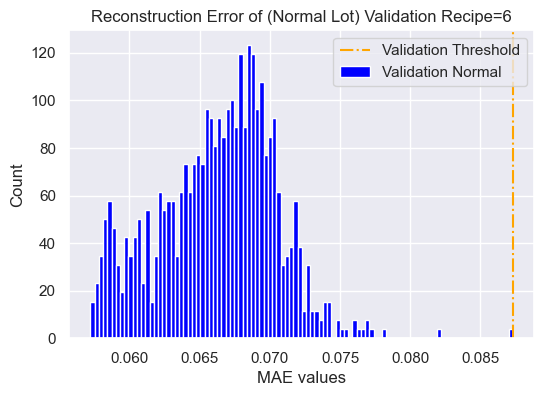

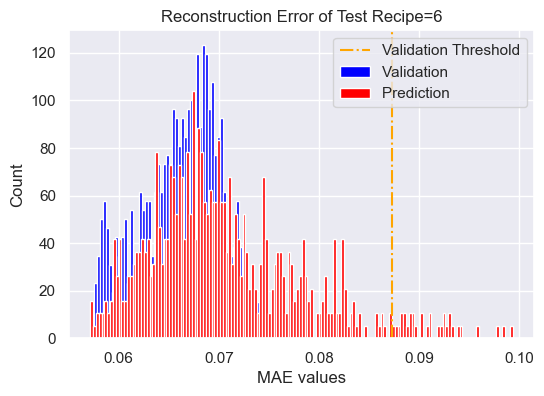

,clusterSetting,good_qty_sum,bad_qty_sum,lot_fault_ratio,good_pred,bad_pred,pred_fault_ratio
lot_no,,,,,,,
20240124,63.0,680.0,2.0,0.293255,650,32,4.692082


In [37]:
train_number = 5
val_number = 63
test_number = 63

train_setting = train[train['clusterSetting']==train_number].reset_index(drop=True)
matched_setting = test[test['clusterSetting']==test_number].reset_index(drop=True)

normal_val = train[train['clusterSetting']==val_number].reset_index(drop=True)
test_fault = matched_setting 

print(normal_val.shape, test_fault.shape)

result_cluster_63 = kl_test(train_number,val_number,test_number)
result_cluster_63

In [27]:
df_test_clusters = test
set_cols = df_test_clusters.loc[:, df_test_clusters.columns.str.contains('param')].columns.tolist()

test_settings = df_test_clusters[set_cols+['clusterSetting']]
test_settings['clusterSetting'].value_counts()

5      5584
118    2833
182     971
40      732
63      682
23      475
Name: clusterSetting, dtype: int64

In [28]:
def find_nearest_settings(number):
    cluster_settings = [5,23,182] #trained_settings['clusterSetting'].unique().tolist()
    dfs = []
    for i in range(0,len(cluster_settings)):
        trained_cluster = trained_settings[trained_settings['clusterSetting']==cluster_settings[i]].reset_index(drop=True)
        trained_cluster = trained_cluster.drop(['clusterSetting'],axis=1).drop_duplicates()
        test_cluster = test_settings[test_settings['clusterSetting']==number].reset_index(drop=True)
        test_cluster = test_cluster.drop(['clusterSetting'],axis=1).drop_duplicates()
        kl_divergence = kl_div(trained_cluster, test_cluster).T.sum().iloc[0] # sum
        if kl_divergence == math.inf:
            kl_divergence= kl_div(test_cluster, trained_cluster).T.sum().iloc[0] # sum
        else:
            pass
        list_a = [cluster_settings[i],kl_divergence]
        dfs.append(list_a)
    lists_df = pd.DataFrame(dfs).rename(columns={0:'cluster_setting',1:'kl_div'})
    lists_df = lists_df[lists_df['kl_div']>=0]
    lists_df = lists_df.sort_values(by='kl_div',ascending=True).reset_index(drop=True)
    closest_list = lists_df[lists_df['kl_div']== lists_df['kl_div'].min()]
    closest_setting =  closest_list['cluster_setting'].iloc[0]
    return lists_df

In [29]:
find_nearest_settings(40)

,cluster_setting,kl_div
0,5,11.130100
1,182,12.153867
2,23,12.664364


In [30]:
find_nearest_settings(118)

,cluster_setting,kl_div
0,23,0.604040
1,5,2.535512
2,182,3.559279


In [31]:
find_nearest_settings(5)

,cluster_setting,kl_div
0,5,0.000000
1,182,1.023767
2,23,1.534264


In [32]:
find_nearest_settings(23)

,cluster_setting,kl_div
0,23,0.000000
1,5,1.931472
2,182,2.955239


(3073, 132) (732, 132)
0.10550220957107533




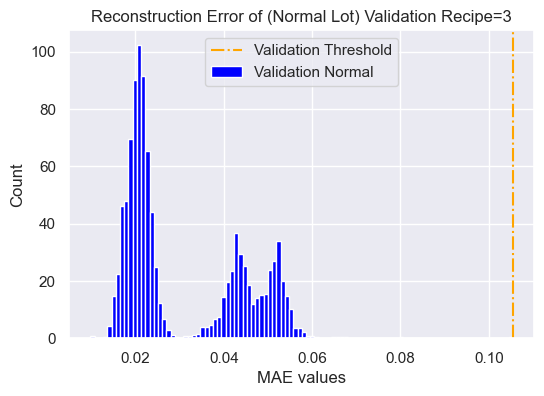

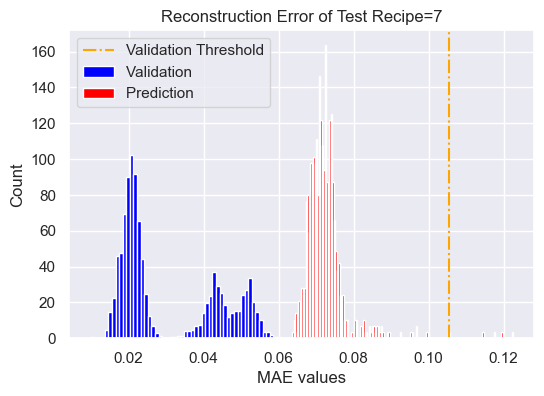

,clusterSetting,good_qty_sum,bad_qty_sum,lot_fault_ratio,good_pred,bad_pred,pred_fault_ratio
lot_no,,,,,,,
20240206,40.0,728.0,4.0,0.546448,727,5,0.68306


In [40]:
train_number = 5
val_number = 182 # 63
test_number = 40

train_setting = train[train['clusterSetting']==train_number].reset_index(drop=True)
matched_setting = test[test['clusterSetting']==test_number].reset_index(drop=True)

normal_val = train[train['clusterSetting']==val_number].reset_index(drop=True)
test_fault = matched_setting 

print(normal_val.shape, test_fault.shape)

result_cluster_63 = kl_test(train_number,val_number,test_number)
result_cluster_63

Train Shape ==> (6552, 6)
Epoch 1/200
42/56 [=====================>........] - ETA: 0s - loss: 0.2542
Epoch 00001: val_loss improved from inf to 0.17023, saving model to autoencoder_item.h5
56/56 [==============================] - 1s 6ms/step - loss: 0.2337 - val_loss: 0.1702
Epoch 2/200
40/56 [====================>.........] - ETA: 0s - loss: 0.1673
Epoch 00002: val_loss improved from 0.17023 to 0.16836, saving model to autoencoder_item.h5
56/56 [==============================] - 0s 4ms/step - loss: 0.1670 - val_loss: 0.1684
Epoch 3/200
36/56 [==================>...........] - ETA: 0s - loss: 0.1576
Epoch 00003: val_loss improved from 0.16836 to 0.05241, saving model to autoencoder_item.h5
56/56 [==============================] - 0s 4ms/step - loss: 0.1272 - val_loss: 0.0524
Epoch 4/200
46/56 [=======================>......] - ETA: 0s - loss: 0.0542
Epoch 00004: val_loss improved from 0.05241 to 0.04665, saving model to autoencoder_item.h5
56/56 [==============================] - 0s 3

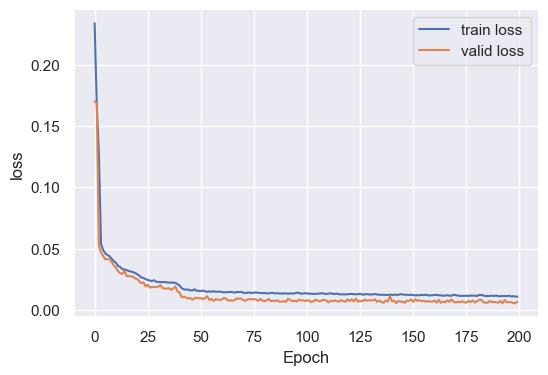

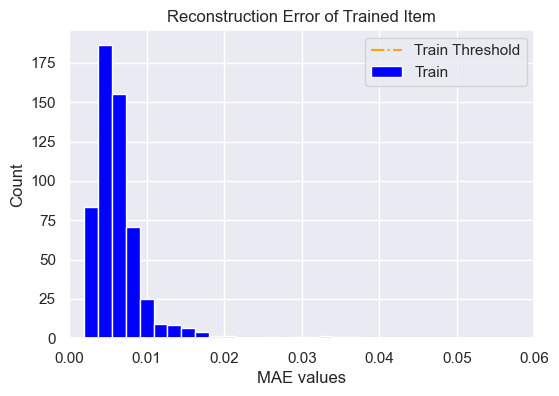



Train (Normal Only) Reconstruction error threshold: 0.1802202811202522




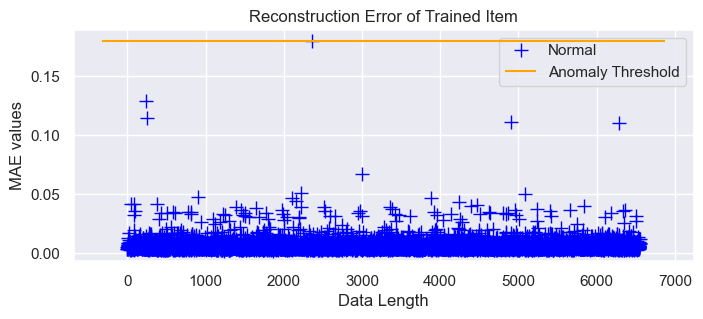

0    6552
Name: score, dtype: int64


Valid Shape ==> (1638, 6)


+ Max Validation Threshold= 0.1255956304878956


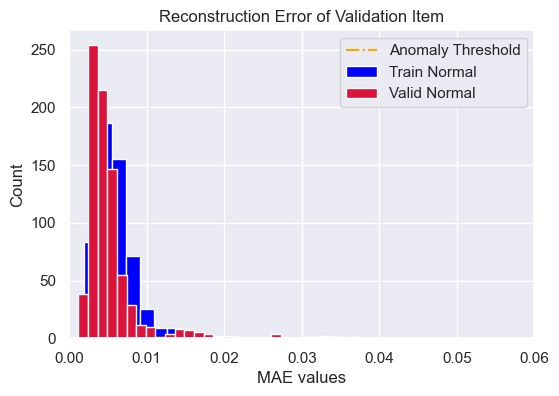

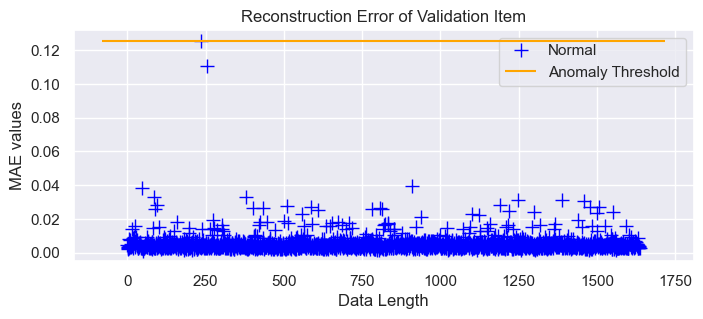

0    1638
Name: score, dtype: int64


Test Setting Cluster Number= 40
Test Shape ==> (732, 6)


+ Max Validation Threshold= 0.1255956304878956


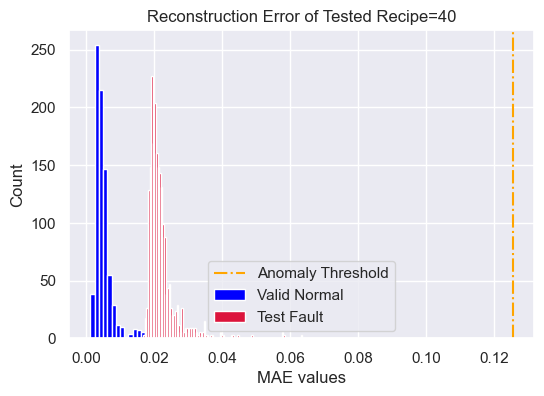

추가 시도 대기 ==>
+ Max Validation Threshold= 0.1255956304878956


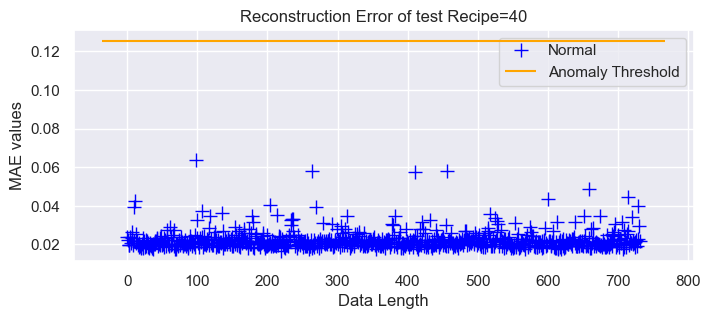

0    732
Name: score, dtype: int64




,clusterSetting,good_qty_sum,bad_qty_sum,lot_fault_ratio,good_pred,bad_pred,pred_fault_ratio
lot_no,,,,,,,
20240206,40.0,728.0,4.0,0.546448,732,0,0.0


In [58]:
df_pred = autoencoder(train_number=100,test_number=40,test=test)

cluster = 40
test_cluster = test[test['clusterSetting']==cluster].reset_index(drop=True)
test_cluster = test_cluster[['clusterSetting','lot_no','lot_fault_ratio','good_qty_sum','bad_qty_sum']]
result = pd.concat([test_cluster,df_pred[['mae_loss','threshold','score','anomaly']]],axis=1)
result['good_pred'] = result['score'].replace({0:1,1:0}) 
result['bad_pred'] = result['score']
count = result.groupby('lot_no')[['clusterSetting','good_qty_sum','bad_qty_sum']].mean()
lot_fault_ratio = result.groupby('lot_no')[['lot_fault_ratio']].mean()
pred_count = result.groupby('lot_no')[['good_pred','bad_pred']].sum()
sum = result.groupby('lot_no')[['good_pred','bad_pred']].sum()['bad_pred'] + result.groupby('lot_no')[['good_pred','bad_pred']].sum()['good_pred']
pred_fault_ratio = pd.DataFrame((result.groupby('lot_no')[['good_pred','bad_pred']].sum()['bad_pred']/sum)*100).rename(columns={0:'pred_fault_ratio'})
result_cluster40 = pd.concat([count,lot_fault_ratio,pred_count,pred_fault_ratio],axis=1)
result_cluster40

Train Shape ==> (6552, 6)
Epoch 1/200
51/56 [==========================>...] - ETA: 0s - loss: 0.2396
Epoch 00001: val_loss improved from inf to 0.17023, saving model to autoencoder_item.h5
56/56 [==============================] - 1s 8ms/step - loss: 0.2337 - val_loss: 0.1702
Epoch 2/200
46/56 [=======================>......] - ETA: 0s - loss: 0.1671
Epoch 00002: val_loss improved from 0.17023 to 0.16836, saving model to autoencoder_item.h5
56/56 [==============================] - 0s 5ms/step - loss: 0.1670 - val_loss: 0.1684
Epoch 3/200
51/56 [==========================>...] - ETA: 0s - loss: 0.1332
Epoch 00003: val_loss improved from 0.16836 to 0.05241, saving model to autoencoder_item.h5
56/56 [==============================] - 0s 5ms/step - loss: 0.1272 - val_loss: 0.0524
Epoch 4/200
47/56 [========================>.....] - ETA: 0s - loss: 0.0542
Epoch 00004: val_loss improved from 0.05241 to 0.04665, saving model to autoencoder_item.h5
56/56 [==============================] - 0s 5

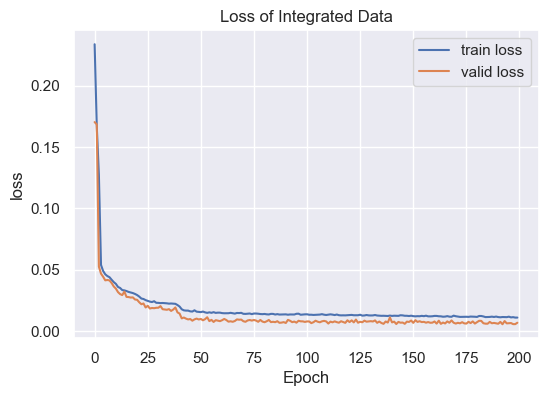

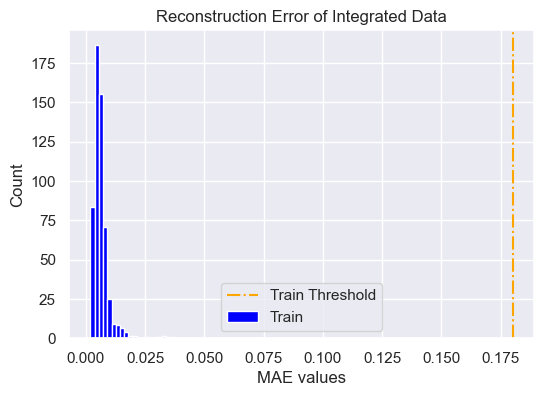



Train (Normal Only) Reconstruction error threshold: 0.1802202811202522




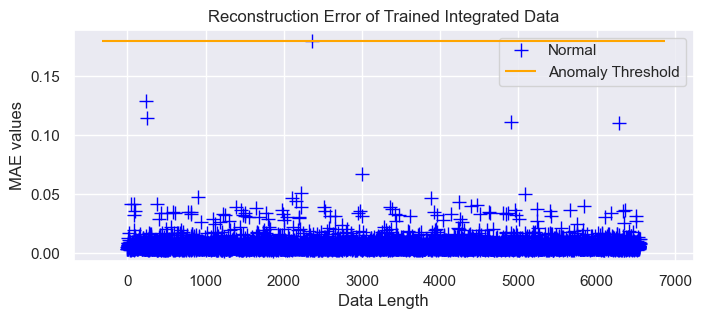

0    6552
Name: score, dtype: int64


Valid Shape ==> (1638, 6)


+ Max Validation Threshold= 0.1255956304878956


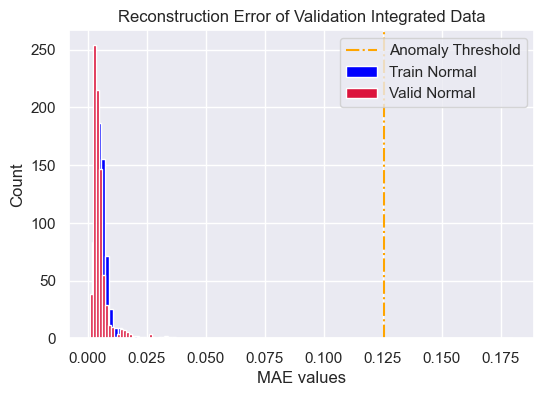

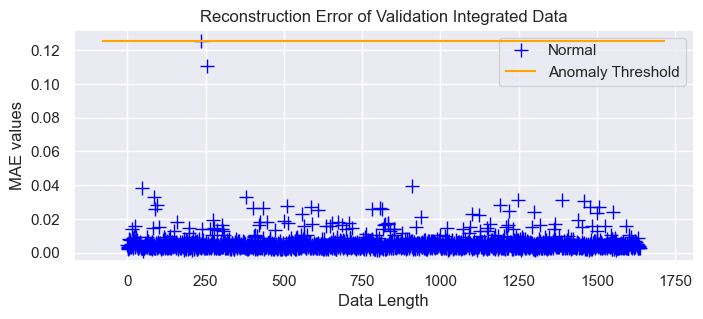

0    1638
Name: score, dtype: int64


Test Setting Cluster Number= 63
Test Shape ==> (682, 6)


+ Max Validation Threshold= 0.1255956304878956


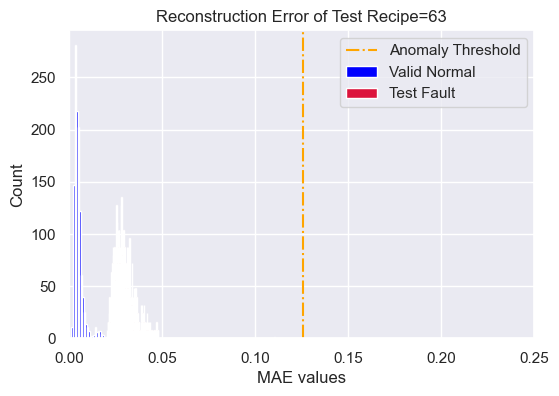

추가 시도 대기 ==>
+ Max Validation Threshold= 0.1255956304878956


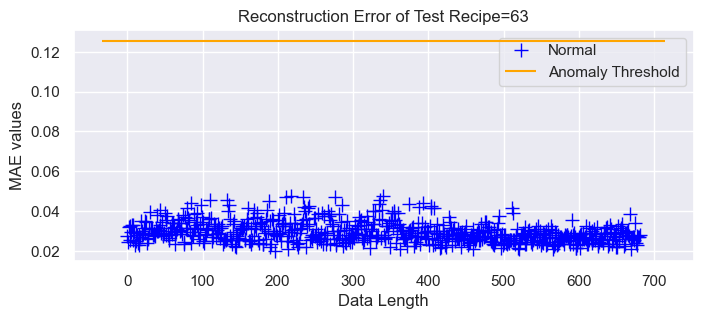

0    682
Name: score, dtype: int64




NameError: name 'result_cluster53' is not defined

In [34]:
df_pred = autoencoder(train_number=100,test_number=63,test=test)

cluster = 63
test_cluster = test[test['clusterSetting']==cluster].reset_index(drop=True)
test_cluster = test_cluster[['clusterSetting','lot_no','lot_fault_ratio','good_qty_sum','bad_qty_sum']]
result = pd.concat([test_cluster,df_pred[['mae_loss','threshold','score','anomaly']]],axis=1)
result['good_pred'] = result['score'].replace({0:1,1:0}) 
result['bad_pred'] = result['score']
count = result.groupby('lot_no')[['clusterSetting','good_qty_sum','bad_qty_sum']].mean()
lot_fault_ratio = result.groupby('lot_no')[['lot_fault_ratio']].mean()
pred_count = result.groupby('lot_no')[['good_pred','bad_pred']].sum()
sum = result.groupby('lot_no')[['good_pred','bad_pred']].sum()['bad_pred'] + result.groupby('lot_no')[['good_pred','bad_pred']].sum()['good_pred']
pred_fault_ratio = pd.DataFrame((result.groupby('lot_no')[['good_pred','bad_pred']].sum()['bad_pred']/sum)*100).rename(columns={0:'pred_fault_ratio'})
result_cluster63 = pd.concat([count,lot_fault_ratio,pred_count,pred_fault_ratio],axis=1)
result_cluster63

In [35]:
result_cluster63

,clusterSetting,good_qty_sum,bad_qty_sum,lot_fault_ratio,good_pred,bad_pred,pred_fault_ratio
lot_no,,,,,,,
20240124,63.0,680.0,2.0,0.293255,682,0,0.0
